In [24]:
%pip -q install --upgrade snowflake-connector-python awswrangler shap xgboost joblib

# ============================================================
# 1) Imports, setup, logging
# ============================================================
from __future__ import annotations
import os, json, logging, warnings
from dataclasses import dataclass
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import awswrangler as wr
import joblib
import snowflake.connector as sf
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import shap
from dataclasses import dataclass, field
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")
plt.rcParams["figure.figsize"] = (6.4, 4.8)
SEED = 42
np.random.seed(SEED)



@dataclass(frozen=True)
class CFG:
    # --- AWS / S3 ---
    AWS_REGION: str = os.environ.get("AWS_REGION", "us-east-2")
    S3_BUCKET: str = "csvclima01"
    S3_PREFIX: str = ""

    SECRET_NAME: str = "snowflake/ons_prod"

    START_DATE: str = "2024-01-01"
    END_DATE: str = "2025-12-12"
    SUBSISTEMA: str = "SUDESTE/CENTRO-OESTE"

    TARGET: str = "NIVEL_RISCO_CATEGORIA2"
    ORD_MAP: Dict[str, int] = field(
        default_factory=lambda: {"Baixo": 0, "Medio": 1, "Alto": 2}
    )
    TRAIN_FRAC: float = 0.60

    # --- Modelos ---
    RF_ESTIMATORS: int = 600
    RF_NJOBS: int = -1
    XGB_PARAMS: Dict = field(
        default_factory=lambda: dict(
            n_estimators=800,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="multi:softprob",
            random_state=SEED,
            n_jobs=-1,
            reg_lambda=1.0,
        )
    )
    # --- SHAP ---
    SHAP_BG_MAX: int = 500

cfg = CFG()



# --- Config Snowflake 
ACCOUNT   = "ZMJNSTX-EY20159" 
USER      = "AWSPOSIFIF"
WAREHOUSE = "LAB_WH"
DATABASE  = "LAB_ONS"
SCHEMA    = "CORE_ONS"
ROLE      = None  

import getpass
PASSWORD  = getpass.getpass("Senha do Snowflake: ")  # pede na hora

import snowflake.connector as sf
import logging, json, boto3

USE_SECRETS_MANAGER = False         
AWS_REGION_SM = "us-east-2"         

def get_sf_conn():
    """
    Retorna uma conexão Snowflake.
    - Se USE_SECRETS_MANAGER=True e houver permissão, lê do Secrets Manager.
    - Caso contrário, usa as constantes definidas acima (sem env vars).
    """
    if USE_SECRETS_MANAGER:
        try:
            sm = boto3.client("secretsmanager", region_name=AWS_REGION_SM)
            sec = json.loads(sm.get_secret_value(SecretId=SECRET_NAME)["SecretString"])
            account   = sec.get("account", ACCOUNT)
            user      = sec.get("user", USER)
            password  = sec.get("password", PASSWORD)
            warehouse = sec.get("warehouse", WAREHOUSE)
            database  = sec.get("database", DATABASE)
            schema    = sec.get("schema", SCHEMA)
            role      = sec.get("role", ROLE)
            logging.info("Credenciais Snowflake via Secrets Manager.")
        except Exception as e:
            logging.warning(f"Não foi possível usar Secrets Manager ({e}). Usando constantes locais.")
            account, user, password = ACCOUNT, USER, PASSWORD
            warehouse, database, schema, role = WAREHOUSE, DATABASE, SCHEMA, ROLE
    else:
        account, user, password = ACCOUNT, USER, PASSWORD
        warehouse, database, schema, role = WAREHOUSE, DATABASE, SCHEMA, ROLE

    conn = sf.connect(
        account=account,
        user=user,
        password=password,
        warehouse=warehouse,
        database=database,
        schema=schema,
        role=role  
    )
    return conn

Note: you may need to restart the kernel to use updated packages.


Senha do Snowflake:  ········


In [26]:
# --- filtros ---
DATA_INI = cfg.START_DATE      # ex: "2024-01-01"
DATA_FIM = cfg.END_DATE        # ex: "2025-09-30"
SUBSISTEMA_LIKE = "%SUDESTE%"  

ONS_SQL = """
WITH fc_go AS (
  SELECT
    DATA_OPERACAO AS DATA_REFERENCIA,
    AVG(FATOR_CAPACIDADE_MEDIO_PCT) AS FC_MEDIO_PCT
  FROM LAB_ONS.CORE_ONS.FATO_FATOR_CAPACIDADE_DIARIO
  WHERE DATA_OPERACAO BETWEEN %(data_ini)s AND %(data_fim)s
  GROUP BY 1
)
SELECT
  r.DATA_REFERENCIA,
  r.NOM_SUBSISTEMA,
  r.NIVEL_RISCO_CATEGORIA,
  r.SCORE_RISCO_NUMERICO,
  b.TOTAL_GERACAO_MWH_DIA,
  b.CARGA_MWH_DIA,
  b.INTERCAMBIO_MW_MEDIO_DIA,
  res.EAR_PERCENTUAL,
  f.FC_MEDIO_PCT
FROM LAB_ONS.CORE_ONS.FATO_RISCO_ENERGETICO_DIARIO r
LEFT JOIN LAB_ONS.CORE_ONS.FATO_BALANCO_ENERGETICO_DIARIO b
       ON b.DATA_REFERENCIA = r.DATA_REFERENCIA
      AND b.ID_SUBSISTEMA   = r.ID_SUBSISTEMA
LEFT JOIN LAB_ONS.CORE_ONS.FATO_RESERVATORIO_ENERGIA_DIARIO res
       ON res.DATA_REFERENCIA = r.DATA_REFERENCIA
      AND res.ID_SUBSISTEMA   = r.ID_SUBSISTEMA
LEFT JOIN fc_go f
       ON f.DATA_REFERENCIA = r.DATA_REFERENCIA
WHERE r.NOM_SUBSISTEMA ILIKE '%%SUDESTE%%'
  AND r.DATA_REFERENCIA BETWEEN %(data_ini)s AND %(data_fim)s
ORDER BY r.DATA_REFERENCIA
LIMIT 5000;
"""

def read_ons_from_snowflake() -> pd.DataFrame:
    params = {"data_ini": DATA_INI, "data_fim": DATA_FIM, "subsistema_like": SUBSISTEMA_LIKE}
    conn = get_sf_conn()
    try:
        df = pd.read_sql(ONS_SQL, conn, params=params)
        df["DATA_REFERENCIA"] = pd.to_datetime(df["DATA_REFERENCIA"]).dt.normalize()
        return df
    finally:
        conn.close()


def read_clima_from_s3() -> pd.DataFrame:
    s3_path = f"s3://{cfg.S3_BUCKET}/" if cfg.S3_PREFIX == "" else f"s3://{cfg.S3_BUCKET}/{cfg.S3_PREFIX.strip('/')}/"
    logging.info(f"Lendo INMET do S3: {s3_path}*.csv")
    df_all = wr.s3.read_csv(
        path=s3_path,
        path_suffix=[".CSV", ".csv"],
        sep=";", skiprows=8, decimal=",", encoding="latin-1",
        dtype_backend="pyarrow", use_threads=True
    )

    ren = {
        "Data":"data", "Hora UTC":"hora_utc",
        "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)": "precipitacao_mm",
        "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)": "temp_c",
        "UMIDADE RELATIVA DO AR, HORARIA (%)": "umidade_relativa",
        "VENTO, VELOCIDADE HORARIA (m/s)": "vento_velocidade_ms"
    }
    for k,v in ren.items():
        if k in df_all.columns: df_all = df_all.rename(columns={k:v})

    keep = ["data","hora_utc","precipitacao_mm","temp_c","umidade_relativa","vento_velocidade_ms"]
    for c in keep:
        if c not in df_all.columns: df_all[c] = np.nan
    df = df_all[keep].copy()

    h = df["hora_utc"].astype(str).str.replace(" UTC","", regex=False).str.replace(":","", regex=False).str.zfill(4)
    df["data_hora"] = pd.to_datetime(df["data"].astype(str)+" "+h, format="%Y/%m/%d %H%M", errors="coerce")
    df = df.sort_values("data_hora").ffill()

    di = (df.set_index("data_hora")
            .resample("D")
            .agg({
                "precipitacao_mm":"sum",
                "temp_c":["mean","max","min"],
                "umidade_relativa":"mean",
                "vento_velocidade_ms":"mean"
            }))
    di.columns = ["_".join([c for c in col if c]) for col in di.columns]  # flatten
    di = di.reset_index().rename(columns={"data_hora":"DATA_REFERENCIA"})
    di["DATA_REFERENCIA"] = pd.to_datetime(di["DATA_REFERENCIA"]).dt.normalize()
    return di


def build_features(df_ons: pd.DataFrame, df_clima: pd.DataFrame) -> pd.DataFrame:
    df = (df_ons
          .merge(df_clima, on="DATA_REFERENCIA", how="left")
          .sort_values("DATA_REFERENCIA")
          .reset_index(drop=True))

    # lags/tendências ONS
    df["INTERCAMBIO_MW_MEDIO_DIA_d-1"] = df["INTERCAMBIO_MW_MEDIO_DIA"].shift(1)
    df["INTERCAMBIO_MW_MEDIO_DIA_7d"]  = df["INTERCAMBIO_MW_MEDIO_DIA"].rolling(7).mean().shift(1)
    df["INTERCAMBIO_MW_MEDIO_DIA_min_7d"] = df["INTERCAMBIO_MW_MEDIO_DIA"].rolling(7).min().shift(1)
    df["CARGA_MWH_DIA_d-1"] = df["CARGA_MWH_DIA"].shift(1)
    df["TOTAL_GERACAO_MWH_DIA_d-1"] = df["TOTAL_GERACAO_MWH_DIA"].shift(1)
    df["EAR_PERCENTUAL_d-1"] = df["EAR_PERCENTUAL"].shift(1)
    df["FC_MEDIO_PCT_d-1"] = df["FC_MEDIO_PCT"].shift(1)

    imp = (-df["INTERCAMBIO_MW_MEDIO_DIA"]).clip(lower=0)
    df["IMPORT_RATIO"] = imp / df["CARGA_MWH_DIA"].replace(0, np.nan)
    df["IMPORT_RATIO_d-1"] = df["IMPORT_RATIO"].shift(1)
    df["IMPORT_RATIO_mean_7d"] = df["IMPORT_RATIO"].rolling(7).mean().shift(1)
    df["IMPORT_RATIO_max_7d"] = df["IMPORT_RATIO"].rolling(7).max().shift(1)

    # clima -> lags/janelas úteis
    df["TEMP_MEDIA_C_d-1"]   = df["temp_c_mean"].shift(1)
    df["TEMP_MEDIA_C_7d"]    = df["temp_c_mean"].rolling(7).mean().shift(1)
    df["TEMP_MAX_C_d-1"]     = df["temp_c_max"].shift(1)
    df["TEMP_MAX_C_7d"]      = df["temp_c_max"].rolling(7).mean().shift(1)
    df["TEMP_AMPLITUDE_C_d-1"]= (df["temp_c_max"]-df["temp_c_min"]).shift(1)
    df["TEMP_AMPLITUDE_C_7d"] = (df["temp_c_max"]-df["temp_c_min"]).rolling(7).mean().shift(1)
    df["PRECIP_SOMA_7d"]     = df["precipitacao_mm_sum"].rolling(7).sum().shift(1)
    df["PRECIP_SOMA_30d"]    = df["precipitacao_mm_sum"].rolling(30).sum().shift(1)
    df["UMID_MEDIA_7d"]         = df["umidade_relativa_mean"].rolling(7).mean().shift(1)
    df["VENTO_MEDIA_7d"]        = df["vento_velocidade_ms_mean"].rolling(7).mean().shift(1)

    # calendário
    df["MES"] = df["DATA_REFERENCIA"].dt.month
    df["DOW"] = df["DATA_REFERENCIA"].dt.dayofweek
    df["E_FINALDESEMANA"] = (df["DOW"]>=5).astype(int)

    try:
        import holidays
        br = holidays.Brazil()
        fer = df["DATA_REFERENCIA"].isin(pd.to_datetime(list(br))).astype(int)
        df["E_FERIADO"] = fer
        df["E_VESPERA_FERIADO"] = df["DATA_REFERENCIA"].shift(-1).isin(pd.to_datetime(list(br))).astype(int)
        df["E_POS_FERIADO"] = df["DATA_REFERENCIA"].shift(1).isin(pd.to_datetime(list(br))).astype(int)
    except Exception:
        for c in ["E_FERIADO","E_VESPERA_FERIADO","E_POS_FERIADO"]:
            if c not in df: df[c]=0

    # estatísticas móveis (14d) para algumas colunas
    for col in ["IMPORT_RATIO_d-1","INTERCAMBIO_MW_MEDIO_DIA_d-1","CARGA_MWH_DIA_d-1","EAR_PERCENTUAL_d-1"]:
        df[f"{col}_mean_14d"] = df[col].rolling(14, min_periods=5).mean()
        df[f"{col}_std_14d"]  = df[col].rolling(14, min_periods=5).std()

    # stress hídrico
    df["STRESS_HIDRICO"] = (100 - df["EAR_PERCENTUAL_d-1"]) * np.maximum(0, df["IMPORT_RATIO_d-1"])

    # limpeza
    df = df.dropna().reset_index(drop=True)
    return df



SISTEMA_KEEP = [
    "INTERCAMBIO_MW_MEDIO_DIA_d-1","INTERCAMBIO_MW_MEDIO_DIA_7d","INTERCAMBIO_MW_MEDIO_DIA_min_7d",
    "CARGA_MWH_DIA_d-1","TOTAL_GERACAO_MWH_DIA_d-1","EAR_PERCENTUAL_d-1","FC_MEDIO_PCT_d-1",
    "INTERCAMBIO_MW_MEDIO_DIA_d-1_mean_14d","INTERCAMBIO_MW_MEDIO_DIA_d-1_std_14d",
    "CARGA_MWH_DIA_d-1_mean_14d","CARGA_MWH_DIA_d-1_std_14d",
    "EAR_PERCENTUAL_d-1_mean_14d","EAR_PERCENTUAL_d-1_std_14d",
    "IMPORT_RATIO_d-1","IMPORT_RATIO_d-1_mean_14d","IMPORT_RATIO_d-1_std_14d","STRESS_HIDRICO"
]
CLIMA_KEEP = [
    "TEMP_MEDIA_C_d-1","TEMP_MEDIA_GO_C_7d","TEMP_MAX_C_d-1","TEMP_MAX_C_7d",
    "TEMP_AMPLITUDE_C_d-1","TEMP_AMPLITUDE_C_7d",
    "PRECIP_SOMA_7d","PRECIP_SOMA_30d","UMID_MEDIA_7d","VENTO_MEDIA_7d"
]
FLAGS_KEEP = ["E_FINALDESEMANA","E_FERIADO","E_VESPERA_FERIADO","E_POS_FERIADO"]

def uniq(seq: List[str]) -> List[str]: return list(dict.fromkeys(seq))

def build_dataset(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, List[str]]:
    # codificação cíclica
    df["MES_sin"] = np.sin(2*np.pi*(df["MES"]-1)/12)
    df["MES_cos"] = np.cos(2*np.pi*(df["MES"]-1)/12)
    df["DOW_sin"] = np.sin(2*np.pi*df["DOW"]/7)
    df["DOW_cos"] = np.cos(2*np.pi*df["DOW"]/7)

    feature_list = uniq(SISTEMA_KEEP + CLIMA_KEEP + FLAGS_KEEP + ["MES_sin","MES_cos","DOW_sin","DOW_cos"])
    feature_list = [c for c in feature_list if c in df.columns]

    X = df[feature_list].copy().ffill().bfill()
    y = df[cfg.TARGET].map(cfg.ORD_MAP).astype(int)
    return X, y, feature_list

In [27]:
df_ons   = read_ons_from_snowflake()

2025-10-17 00:26:42,956 | INFO | Snowflake Connector for Python Version: 4.0.0, Python Version: 3.12.9, Platform: Linux-6.1.150-174.273.amzn2023.x86_64-x86_64-with-glibc2.35
2025-10-17 00:26:42,958 | INFO | Connecting to GLOBAL Snowflake domain


In [28]:
df_clima = read_clima_from_s3()
df       = build_features(df_ons, df_clima)
logging.info(f"Base consolidada: {df.shape}")

limite_risco_alto = df['INTERCAMBIO_MW_MEDIO_DIA'].quantile(0.20)
# Risco Baixo: dias com maior SUPERÁVIT (os 50% MAIORES/MAIS POSITIVOS valores de intercâmbio)
limite_risco_baixo = df['INTERCAMBIO_MW_MEDIO_DIA'].quantile(0.50)

def classificar_risco_correto(intercambio_mean):
    if intercambio_mean <= limite_risco_alto:
        return 'Alto'
    elif intercambio_mean > limite_risco_alto and intercambio_mean <= limite_risco_baixo:
        return 'Medio'
    else:
        return 'Baixo'

df['NIVEL_RISCO_CATEGORIA2'] = df['INTERCAMBIO_MW_MEDIO_DIA'].apply(classificar_risco_correto)

print("Nova distribuição das classes:")
print(df['NIVEL_RISCO_CATEGORIA2'].value_counts(normalize=True))

2025-10-17 00:26:50,514 | INFO | Lendo INMET do S3: s3://csvclima01/*.csv
2025-10-17 00:28:27,259 | INFO | Base consolidada: (579, 51)


Nova distribuição das classes:
NIVEL_RISCO_CATEGORIA2
Baixo    0.499136
Medio    0.300518
Alto     0.200345
Name: proportion, dtype: float64


In [29]:
SEED = 42
np.random.seed(SEED)

ORD_MAP = {"Baixo":0, "Medio":1, "Alto":2}

def enforce_time_order(X: pd.DataFrame, y: pd.Series):
    """Garante que X e y estejam em ordem temporal consistente."""
    if "DATA_REFERENCIA" in X.columns:
        idx = X["DATA_REFERENCIA"].argsort(kind="mergesort")
        return X.iloc[idx].reset_index(drop=True), y.iloc[idx].reset_index(drop=True)
    if isinstance(X.index, pd.DatetimeIndex):
        Xo = X.sort_index()
        yo = y.loc[Xo.index]
        return Xo.reset_index(drop=True), yo.reset_index(drop=True)
    return X.reset_index(drop=True), y.reset_index(drop=True)

def make_class_weight(y_fold: np.ndarray) -> dict:
    classes = np.unique(y_fold)
    w = compute_class_weight("balanced", classes=classes, y=y_fold)
    return {int(c): float(wi) for c, wi in zip(classes, w)}

def sanitize_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    """Coage tudo para numérico, troca inf por NaN e preenche com 0."""
    out = df.copy()
    for c in out.columns:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    out.replace([np.inf, -np.inf], np.nan, inplace=True)
    return out.fillna(0.0).astype("float64")

def plot_cm(y_true, y_pred, ord_map=ORD_MAP, title="Matriz de Confusão (norm)", cmap="Oranges"):
    labels_ord = sorted(np.unique(y_true))
    class_names = [k for k,_ in sorted(ord_map.items(), key=lambda kv: kv[1])]
    cm = confusion_matrix(y_true, y_pred, labels=labels_ord)
    cm_row = cm / cm.sum(axis=1, keepdims=True)
    fig, ax = plt.subplots(figsize=(6,4.8))
    im = ax.imshow(cm_row, cmap=cmap, vmin=0, vmax=1)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]}\n({cm_row[i,j]:.0%})", ha="center", va="center", fontsize=9)
    ax.set_xticks(range(len(labels_ord))); ax.set_yticks(range(len(labels_ord)))
    ax.set_xticklabels([class_names[i] for i in labels_ord], rotation=25, ha="right")
    ax.set_yticklabels([class_names[i] for i in labels_ord])
    ax.set_title(title); ax.set_xlabel("Predito"); ax.set_ylabel("Verdadeiro")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

def text_report(y_true, y_pred, ord_map=ORD_MAP, header="Relatório"):
    labels_ord = sorted(np.unique(y_true))
    class_names = [k for k,_ in sorted(ord_map.items(), key=lambda kv: kv[1])]
    rep = classification_report(
        y_true, y_pred, labels=labels_ord,
        target_names=[class_names[i] for i in labels_ord],
        output_dict=True, zero_division=0
    )
    rep_df = pd.DataFrame(rep).T.round(3)
    display(rep_df.style.set_caption(header))

def eval_and_report(model_name: str, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    labels_ord = sorted(np.unique(y_test))
    qwk = cohen_kappa_score(y_test, y_pred, weights="quadratic")
    acc = accuracy_score(y_test, y_pred)
    logging.info(f"{model_name}: QWK={qwk:.3f} | ACC={acc:.3f}")

    plot_cm(y_test, y_pred, title=f"Matriz de Confusão (norm) — {model_name}")
    text_report(y_test, y_pred, header=f"Relatório — {model_name}")

    return dict(model=model, y_pred=y_pred, y_proba=y_proba, qwk=qwk, acc=acc)

def explain_shap_tree(model_name, model, X_train, X_test):
    import shap, numpy as np
    shap.initjs()

    cols = list(X_train.columns)
    Xtr = sanitize_numeric_df(X_train)
    Xte = sanitize_numeric_df(X_test)
    bg  = Xtr.sample(min(500, len(Xtr)), random_state=SEED)

    sv = None

    if isinstance(model, XGBClassifier):
        try:
            explainer = shap.TreeExplainer(
                model,
                data=bg,
                feature_perturbation="interventional",
                model_output="predict_proba",  
            )
            sv = explainer(Xte, check_additivity=False)
        except Exception as e1:
            try:
                explainer = shap.Explainer(model.predict_proba, bg)
                sv = explainer(Xte)
            except Exception as e2:
                print("[SHAP] Falhou com XGB (TreeExplainer e Explainer).",
                      f"\nPrimeiro erro: {e1}\nSegundo erro: {e2}")
                return
    else:
        explainer = shap.TreeExplainer(
            model,
            data=bg,
            feature_perturbation="interventional",
            model_output="probability",
        )
        sv = explainer(Xte, check_additivity=False)

    idx_alto = ORD_MAP["Alto"]
    sv_alto = sv[:, :, idx_alto] if sv.values.ndim == 3 else sv[idx_alto]

    shap.plots.beeswarm(sv_alto, max_display=20)
    shap.plots.bar(sv_alto.abs.mean(0))


DEMO_DATES = pd.to_datetime(["2025-08-29", "2025-08-30", "2025-08-31"])
assert "DATA_REFERENCIA" in df.columns

mask_demo  = df["DATA_REFERENCIA"].isin(DEMO_DATES)
df_demo    = df.loc[mask_demo].copy()
df_train   = df.loc[~mask_demo].copy()

print(f"[DEMO] datas: {sorted(DEMO_DATES.strftime('%Y-%m-%d').tolist())}")
print(f"[DEMO] linhas demo={len(df_demo)} | treino={len(df_train)}")

X_full, y_full, feature_list = build_dataset(df_train)   # sua função
X_full, y_full = enforce_time_order(X_full, y_full)
logging.info(f"Features finais ({len(feature_list)}): {feature_list}")

2025-10-17 00:28:27,298 | INFO | Features finais (34): ['INTERCAMBIO_MW_MEDIO_DIA_d-1', 'INTERCAMBIO_MW_MEDIO_DIA_7d', 'INTERCAMBIO_MW_MEDIO_DIA_min_7d', 'CARGA_MWH_DIA_d-1', 'TOTAL_GERACAO_MWH_DIA_d-1', 'EAR_PERCENTUAL_d-1', 'FC_MEDIO_PCT_d-1', 'INTERCAMBIO_MW_MEDIO_DIA_d-1_mean_14d', 'INTERCAMBIO_MW_MEDIO_DIA_d-1_std_14d', 'CARGA_MWH_DIA_d-1_mean_14d', 'CARGA_MWH_DIA_d-1_std_14d', 'EAR_PERCENTUAL_d-1_mean_14d', 'EAR_PERCENTUAL_d-1_std_14d', 'IMPORT_RATIO_d-1', 'IMPORT_RATIO_d-1_mean_14d', 'IMPORT_RATIO_d-1_std_14d', 'STRESS_HIDRICO', 'TEMP_MEDIA_C_d-1', 'TEMP_MAX_C_d-1', 'TEMP_MAX_C_7d', 'TEMP_AMPLITUDE_C_d-1', 'TEMP_AMPLITUDE_C_7d', 'PRECIP_SOMA_7d', 'PRECIP_SOMA_30d', 'UMID_MEDIA_7d', 'VENTO_MEDIA_7d', 'E_FINALDESEMANA', 'E_FERIADO', 'E_VESPERA_FERIADO', 'E_POS_FERIADO', 'MES_sin', 'MES_cos', 'DOW_sin', 'DOW_cos']


[DEMO] datas: ['2025-08-29', '2025-08-30', '2025-08-31']
[DEMO] linhas demo=3 | treino=576


In [30]:
df.tail()

,DATA_REFERENCIA,NOM_SUBSISTEMA,NIVEL_RISCO_CATEGORIA,SCORE_RISCO_NUMERICO,TOTAL_GERACAO_MWH_DIA,CARGA_MWH_DIA,INTERCAMBIO_MW_MEDIO_DIA,EAR_PERCENTUAL,FC_MEDIO_PCT,precipitacao_mm_sum,...,IMPORT_RATIO_d-1_mean_14d,IMPORT_RATIO_d-1_std_14d,INTERCAMBIO_MW_MEDIO_DIA_d-1_mean_14d,INTERCAMBIO_MW_MEDIO_DIA_d-1_std_14d,CARGA_MWH_DIA_d-1_mean_14d,CARGA_MWH_DIA_d-1_std_14d,EAR_PERCENTUAL_d-1_mean_14d,EAR_PERCENTUAL_d-1_std_14d,STRESS_HIDRICO,NIVEL_RISCO_CATEGORIA2
574,2025-08-27,SUDESTE/CENTRO-OESTE,Medio,50,916065.218,1059664.572,-5983.306417,58.4127,0.232602,79.6,...,0.005512,0.000599,-5554.922589,710.391215,1.007654e+06,64531.208538,59.931764,0.839531,0.242469,Baixo
575,2025-08-28,SUDESTE/CENTRO-OESTE,Medio,50,893044.618,1066776.128,-7238.812917,58.1889,0.210576,67.0,...,0.005525,0.000600,-5596.019786,717.838025,1.012696e+06,65714.782895,59.734864,0.850151,0.234819,Medio
576,2025-08-29,SUDESTE/CENTRO-OESTE,Alto,100,874562.855,1067512.134,-8039.553292,57.9846,0.230384,410.4,...,0.005645,0.000673,-5745.669640,826.458948,1.016947e+06,67243.440234,59.536921,0.865408,0.283717,Medio
577,2025-08-30,SUDESTE/CENTRO-OESTE,Medio,50,796204.429,969143.467,-7205.793250,57.8340,0.135647,716.8,...,0.005812,0.000825,-5948.066506,1010.582469,1.021471e+06,68437.967354,59.338329,0.880809,0.316423,Medio
578,2025-08-31,SUDESTE/CENTRO-OESTE,Baixo,20,741926.863,878000.923,-5669.752500,57.7118,0.085342,241.2,...,0.005941,0.000929,-6084.775119,1043.892009,1.023585e+06,66130.583758,59.137843,0.880977,0.313513,Baixo


In [31]:
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=130, gap=7)
splits = list(tscv.split(X_full))

qwk_folds, acc_folds = [], []
for i, (tr_idx, va_idx) in enumerate(splits):
    y_tr, y_va = y_full.iloc[tr_idx], y_full.iloc[va_idx]
    cw_fold = make_class_weight(y_tr)
    rf_cv = RandomForestClassifier(
        n_estimators=600, max_depth=8, min_samples_leaf=5,
        random_state=SEED, n_jobs=-1, class_weight=cw_fold
    ).fit(X_full.iloc[tr_idx], y_tr)
    y_pred = rf_cv.predict(X_full.iloc[va_idx])
    qwk_folds.append(cohen_kappa_score(y_va, y_pred, weights="quadratic"))
    acc_folds.append(accuracy_score(y_va, y_pred))

print(f"[TS-CV] QWK médio = {np.mean(qwk_folds):.3f} ± {np.std(qwk_folds):.3f} | "
      f"ACC médio = {np.mean(acc_folds):.3f} ± {np.std(acc_folds):.3f}")

classes_all = set(np.unique(y_full))
last_good = None
for tr, va in splits:
    if set(np.unique(y_full.iloc[va])) == classes_all:
        last_good = (tr, va)
tr_idx, va_idx = last_good if last_good else splits[-1]

X_train, y_train = X_full.iloc[tr_idx], y_full.iloc[tr_idx]
X_test,  y_test  = X_full.iloc[va_idx], y_full.iloc[va_idx]

class_weight = make_class_weight(y_train)
logging.info(f"class_weight (final): {class_weight}")

Xtr_num = sanitize_numeric_df(X_train)
Xte_num = sanitize_numeric_df(X_test)

2025-10-17 00:28:50,830 | INFO | class_weight (final): {0: 0.9903846153846154, 1: 1.0842105263157895, 2: 0.9363636363636364}


[TS-CV] QWK médio = 0.593 ± 0.141 | ACC médio = 0.710 ± 0.068


2025-10-17 00:31:12,445 | INFO | Treinando RandomForest…
2025-10-17 00:31:15,834 | INFO | RandomForest: QWK=0.747 | ACC=0.831


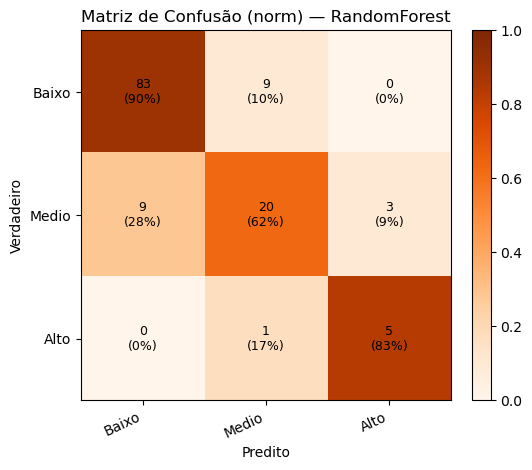

,precision,recall,f1-score,support
Baixo,0.902000,0.902000,0.902000,92.000000
Medio,0.667000,0.625000,0.645000,32.000000
Alto,0.625000,0.833000,0.714000,6.000000
accuracy,0.831000,0.831000,0.831000,0.831000
macro avg,0.731000,0.787000,0.754000,130.000000
weighted avg,0.831000,0.831000,0.830000,130.000000


 98%|===================| 381/390 [00:18<00:00]        

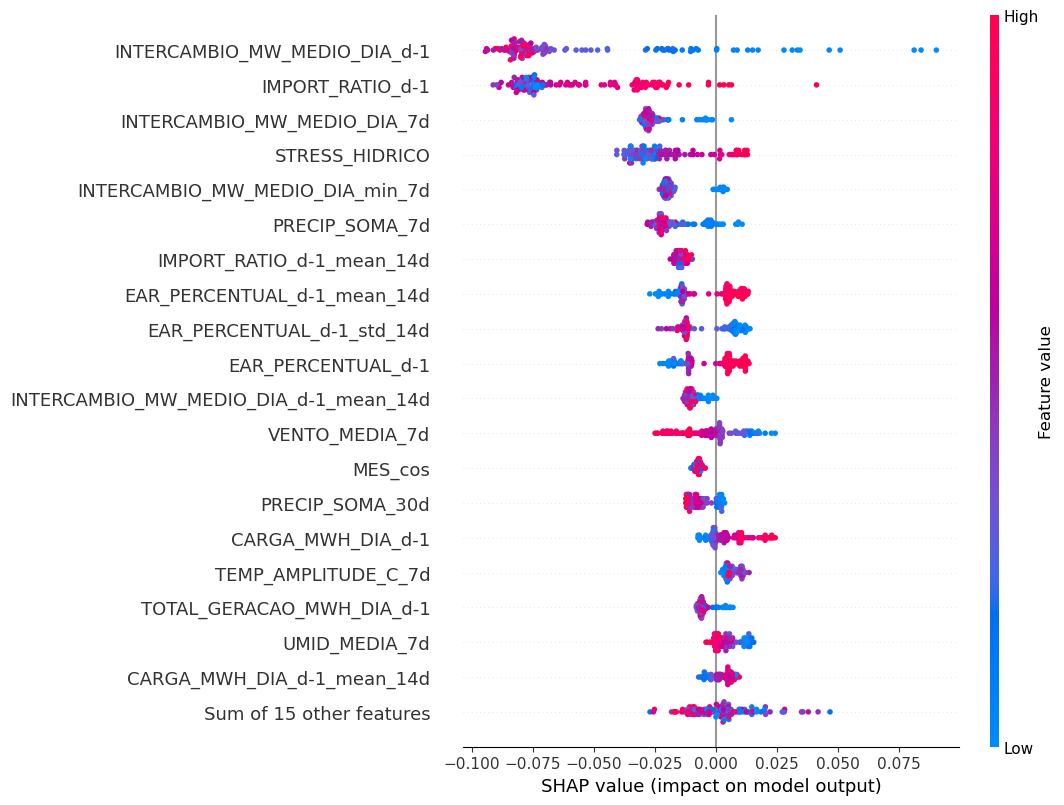

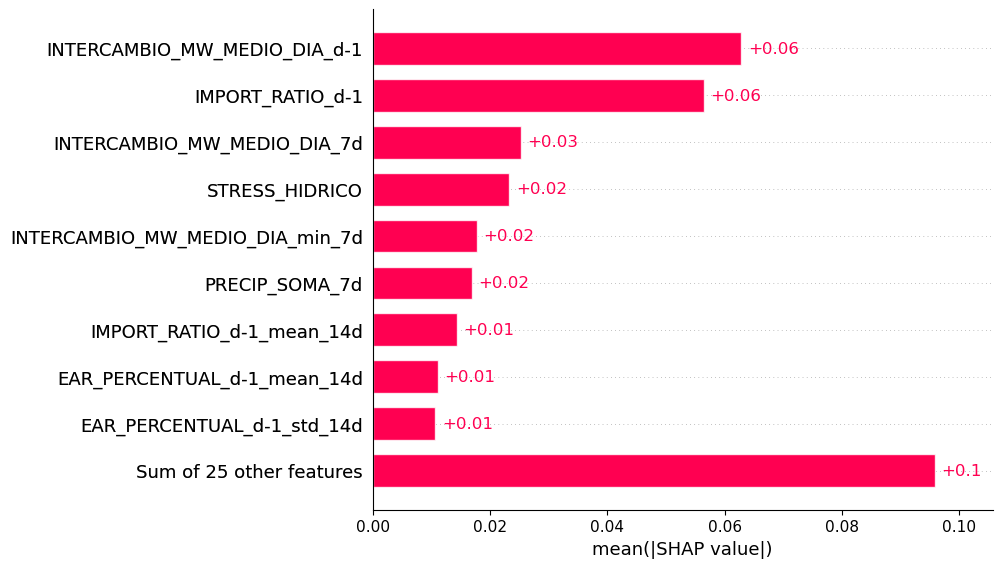

2025-10-17 00:31:35,590 | INFO | Treinando XGBClassifier…
2025-10-17 00:31:37,787 | INFO | XGBClassifier: QWK=0.667 | ACC=0.769


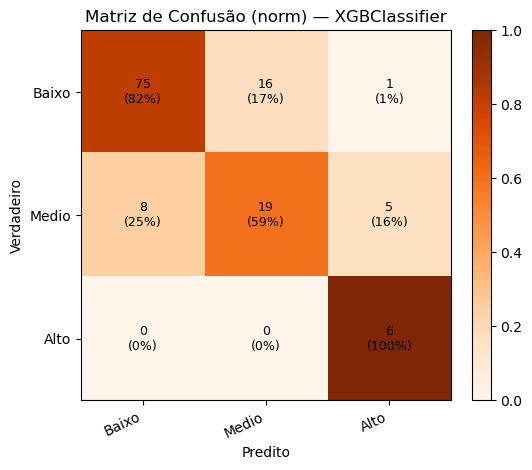

,precision,recall,f1-score,support
Baixo,0.904000,0.815000,0.857000,92.000000
Medio,0.543000,0.594000,0.567000,32.000000
Alto,0.500000,1.000000,0.667000,6.000000
accuracy,0.769000,0.769000,0.769000,0.769000
macro avg,0.649000,0.803000,0.697000,130.000000
weighted avg,0.796000,0.769000,0.777000,130.000000


PermutationExplainer explainer:  36%|███▌      | 47/130 [00:33<00:59,  1.39it/s]

In [ ]:
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=900, max_depth=6, min_samples_leaf=5,
        random_state=SEED, n_jobs=-1, class_weight=class_weight, max_features = "sqrt"
    ),
    "XGBClassifier": XGBClassifier(
        n_estimators=800, max_depth=5, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        objective="multi:softprob", num_class=len(np.unique(y_train)),
        reg_lambda=1.0, random_state=SEED, n_jobs=-1, eval_metric="mlogloss"
    ),
    "LogisticReg": LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=2000,
        class_weight=class_weight, n_jobs=-1
    ),
}


results = {}
for name, model in models.items():
    logging.info(f"Treinando {name}…")
    res = eval_and_report(name, model, Xtr_num, y_train, Xte_num, y_test)
    results[name] = res
    if name in ("RandomForest","XGBClassifier"):
        explain_shap_tree(name, model, Xtr_num, Xte_num)
    joblib.dump(model, f"modelo_{name}.joblib")


cmp = pd.DataFrame([
    dict(model=name, QWK=res["qwk"], ACC=res["acc"])
    for name, res in results.items()
]).sort_values("QWK", ascending=False).reset_index(drop=True)

display(cmp.style.format({"QWK":"{:.3f}","ACC":"{:.3f}"}).set_caption("Comparativo de Modelos"))

with open("features.json","w") as f:
    json.dump(feature_list, f, indent=2)
logging.info("Artefatos salvos: modelos *.joblib, features.json")

In [ ]:
# Grid Search temporal 

from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from sklearn.metrics import cohen_kappa_score, accuracy_score

def make_tscv_safe(n_splits, test_size, gap, n_samples):
    """
    Garante: n_samples - gap - (test_size * n_splits) > 0
    Retorna (n_splits_ok, test_size_ok)
    """
    if test_size is None:
        ns_eff = n_samples - gap
        test_size = max(2, ns_eff // (n_splits + 1))

    ns_eff = n_samples - gap
    if ns_eff <= 2:
        raise ValueError("Poucas amostras úteis para TimeSeriesSplit com o gap informado.")

    max_splits = max(1, (ns_eff - 1) // test_size) 
    n_splits_ok = min(n_splits, max_splits)

    max_test_size = max(2, (ns_eff - 1) // n_splits_ok)
    test_size_ok = min(test_size, max_test_size)

    return n_splits_ok, test_size_ok


param_grid = {
    "n_estimators":     [300, 600, 900],
    "max_depth":        [6, 8, 10],
    "min_samples_leaf": [5, 20, 50],
    "max_features":     ["sqrt", "log2"],
}

Xo, yo = enforce_time_order(X_train, y_train)
n_splits_  = globals().get("n_splits", 4)
gap_       = globals().get("gap", 7)
test_size_ = globals().get("test_size", 130)

n_splits_adj, test_size_adj = make_tscv_safe(n_splits_, test_size_, gap_, n_samples=len(Xo))
print(f"[TSCV-grid] usando n_splits={n_splits_adj}, test_size={test_size_adj}, gap={gap_}")

tscv = TimeSeriesSplit(n_splits=n_splits_adj, test_size=test_size_adj, gap=gap_)
splits = list(tscv.split(Xo))


rows = []
best_params, best_qwk = None, -1e9
total = len(list(ParameterGrid(param_grid)))
for i, params in enumerate(ParameterGrid(param_grid), 1):
    print(f"[{i}/{total}] RF params={params}")
    qwk_folds, acc_folds = [], []

    for tr_idx, va_idx in splits:
        X_tr = sanitize_numeric_df(Xo.iloc[tr_idx])
        y_tr = yo.iloc[tr_idx].astype(int)
        X_va = sanitize_numeric_df(Xo.iloc[va_idx])
        y_va = yo.iloc[va_idx].astype(int)

        cw_fold = make_class_weight(y_tr.values)

        rf = RandomForestClassifier(
            random_state=SEED, n_jobs=-1, class_weight=cw_fold, **params
        )
        rf.fit(X_tr, y_tr)
        y_pr = rf.predict(X_va)

        qwk_folds.append(cohen_kappa_score(y_va, y_pr, weights="quadratic"))
        acc_folds.append(accuracy_score(y_va, y_pr))

    mean_qwk = float(np.mean(qwk_folds)); std_qwk = float(np.std(qwk_folds))
    mean_acc = float(np.mean(acc_folds)); std_acc = float(np.std(acc_folds))
    rows.append({**params, "mean_qwk": mean_qwk, "std_qwk": std_qwk,
                 "mean_acc": mean_acc, "std_acc": std_acc})

    if mean_qwk > best_qwk:
        best_qwk, best_params = mean_qwk, params

grid_df = pd.DataFrame(rows).sort_values("mean_qwk", ascending=False).reset_index(drop=True)
display(
    grid_df.head(10)
           .style.format({"mean_qwk":"{:.3f}","std_qwk":"{:.3f}","mean_acc":"{:.3f}","std_acc":"{:.3f}"})
           .set_caption("Top-10 combinações (QWK) — RandomForest")
)

print(f"[BEST-RF] params={best_params} | QWK médio (TS-CV)={best_qwk:.3f}")


rf_best = RandomForestClassifier(
    random_state=SEED, n_jobs=-1,
    class_weight=class_weight,
    **best_params
)
rf_best.fit(Xtr_num, y_train)


y_pred_best = rf_best.predict(Xte_num)
qwk_best    = cohen_kappa_score(y_test, y_pred_best, weights="quadratic")
acc_best    = accuracy_score(y_test, y_pred_best)
print(f"[RF-BEST] Holdout — QWK={qwk_best:.3f} | ACC={acc_best:.3f}")


try:
    base_qwk = results.get("RandomForest", {}).get("qwk", None)
    base_acc = results.get("RandomForest", {}).get("acc", None)
    if base_qwk is not None:
        print(f"[RF-BASE] Holdout — QWK={base_qwk:.3f} | ACC={base_acc:.3f}")
        print(f"[Δ] QWK: {qwk_best - base_qwk:+.3f} | ACC: {acc_best - base_acc:+.3f}")
except Exception:
    pass

joblib.dump(rf_best, "modelo_RandomForest_grid.joblib")
print("Modelo salvo em: modelo_RandomForest_grid.joblib")
